In [1]:
import numpy as np
from tqdm import tqdm
from echo_lv.data import LV_CAMUS_Dataset, LV_EKB_Dataset
from echo_lv.metrics import dice as dice_np
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import sigmoid
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchsummary import summary
from echo_lv.utils import AverageMeter
import segmentation_models_pytorch as smp
from mod_unet import UNet

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

random_state = 17
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.backends.cudnn.deterministic = True

cuda:1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, padding=0):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=padding),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        for m in self.double_conv:
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        return self.double_conv(x)

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=None):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
        ]
        
        # if dropout:
        #    layers.append(nn.Dropout(dropout))
        self.block = nn.Sequential(*layers)
        for m in self.block:
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        layers = [        
            nn.Conv2d(out_size, out_size, 4, 2, 1, bias=True),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
        ]
        self.down = nn.Sequential(*layers)
        for m in self.down:
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        skip = self.block(x)
        return self.down(skip), skip



class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.block = nn.Sequential(*layers)
        for m in self.block:
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
        layers = [
#             nn.Conv2d(in_size, 2 * in_size, 3, 1, 1),
#             nn.BatchNorm2d(4 * out_size, momentum=0.8),
#             nn.ReLU(inplace=True),
            nn.PixelShuffle(2),
        ]
        self.up = nn.Sequential(*layers)
        for m in self.up:
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x, skip_input):
        x = self.up(x)
        x = torch.cat((x, skip_input), 1)
        x = self.block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.down1 = UNetDown(1, 32)
        self.down2 = UNetDown(32, 64)
        self.down3 = UNetDown(64, 128)  # , dropout=0.5)
        self.down4 = UNetDown(128, 256)  # , dropout=0.5)
        self.down5 = UNetDown(256, 512)  # , dropout=0.5)
        self.down6 = UNetDown(512, 1024)  # , dropout=0.5)
#         self.down8 = UNetDown(1024, 1024, dropout=0.5)
        #
        # self.up1 = UNetUp(1024, 1024, dropout=0.5)
#         self.up6 = UNetUp(1024, 512)  # , dropout=0.5)
        self.up5 = UNetUp(512 + 1024 // 4, 512)  # , dropout=0.5)
        self.up4 = UNetUp(256 + 512 // 4, 256)  # , dropout=0.5)
        self.up3 = UNetUp(128 + 256 // 4, 128)
        self.up2 = UNetUp(64 + 128 // 4, 64)
        self.up1 = UNetUp(32 + 64 // 4, 32)

        self.final = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            # nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            # nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1, skip_1 = self.down1(x)
        d2, skip_2 = self.down2(d1)
        d3, skip_3 = self.down3(d2)
        d4, skip_4 = self.down4(d3)
        d5, skip_5 = self.down5(d4)
        _, d6 = self.down6(d5)
#         d7, _ = self.down7(d6)

        u5 = self.up5(d6, skip_5)
        u4 = self.up4(u5, skip_4)
        u3 = self.up3(u4, skip_3)
        u2 = self.up2(u3, skip_2)
        u1 = self.up1(u2, skip_1)

        return self.final(u1)

In [3]:
model = UNet(in_channels = 1, out_channels = 1).to(device)

In [14]:
# summary(model, (1, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,248
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
            Conv2d-7         [-1, 32, 256, 256]          16,416
       BatchNorm2d-8         [-1, 32, 256, 256]              64
              ReLU-9         [-1, 32, 256, 256]               0
         UNetDown-10  [[-1, 32, 256, 256], [-1, 32, 512, 512]]               0
           Conv2d-11         [-1, 64, 256, 256]          18,496
      BatchNorm2d-12         [-1, 64, 256, 256]             128
             ReLU-13         [-1, 64, 256, 256]               0
           Conv2d-14    

In [4]:
folds = 10
lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=folds)
# lv_camus_valid = LV_CAMUS_Dataset(img_size = (572,572), classes = {0, 1}, folds=10, subset='valid')
lv_camus.set_state('train', 0)
train_loader = DataLoader(lv_camus, batch_size=1, shuffle=True, num_workers=4)

In [5]:
lv_camus.set_state('valid', 0)
imgs, msks, *_ = lv_camus[15]
imgs = torch.tensor(np.expand_dims(imgs, axis=0))
msks = torch.tensor(np.expand_dims(msks, axis=0))

# imgs, msks, *_ = next(iter(valid_loader))

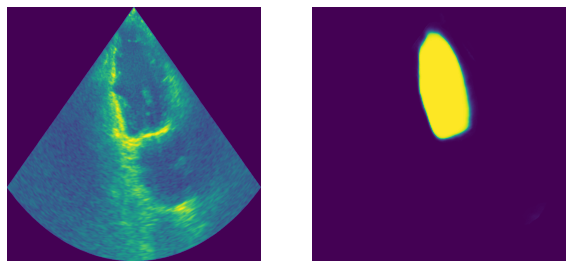

In [9]:
model.eval()
outputs = sigmoid(model(imgs.to(device).float()))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(imgs[0,0,:,:])
plt.axis('off')
plt.subplot(122)
o = outputs[0,0,:,:].cpu().detach().numpy()
plt.imshow(o)
plt.axis('off')
# plt.subplot(133)
m = msks[0,0,:,:].cpu().detach().numpy()
# plt.imshow(m)

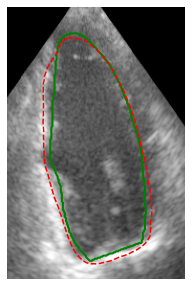

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(imgs[0,0,], cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(180,350)
plt.ylim(20,280)
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_modified_unet.png', bbox_inches='tight', pad_inches=0,)

In [9]:
dice_np(o, m)

0.10373113814904299

In [10]:
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=0)
dice(outputs, msks.to(device))

tensor(0.1037, device='cuda:1', dtype=torch.float64)

In [11]:
criterion = smp.utils.losses.DiceLoss(activation='sigmoid')
criterion(outputs, msks.to(device))

tensor(0.8994, device='cuda:1', dtype=torch.float64, grad_fn=<RsubBackward1>)

In [12]:
lv_camus.set_state(subset='valid', fold=9)
len(lv_camus)

144

In [13]:
lv_camus.set_state(subset='train', fold=9)
len(lv_camus)

1656

In [6]:

epochs = 10



# criterion = torch.nn.functional.binary_cross_entropy_with_logits #DiceLoss_1()
# criterion = smp.utils.losses.DiceLoss(activation='sigmoid')# + smp.utils.losses.BCEWithLogitsLoss()
# weight = 10 * torch.ones((1,1,512,512), device=device)
criterion = smp.utils.losses.DiceLoss(activation='sigmoid')# + smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight) 
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=0.5)#Dice()
iou = smp.utils.metrics.IoU(activation='sigmoid', threshold=0.5)
result = []

for fold in range(1):
    
    model = UNet(in_channels = 1, out_channels = 1).to(device)
    
    optimizer = torch.optim.Adam([
            {'params': model.parameters(), 'lr': 1e-4},   
        ])
    
     # создаем даталодер
    
    
    
    val_dice = 0
    eps = 5e-3
    target_loss = 1e-1
    priveous_loss = 1
    
    t = tqdm(total=epochs, 
            bar_format='{desc} | {postfix[0]}/'+ str(epochs) +' | ' +
            '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | ' +
            '{postfix[5]} : {postfix[6]:>2.4f} | {postfix[7]} : {postfix[8]:>2.4f}',
            postfix=[0, 'loss', 0, 'dice_lv', 0,  
                     'val_loss', 0, 'val_dice_lv', val_dice, 0], 
            desc = 'Train ' + 'unet' +   ' on fold ' + str(fold),
            position=0, leave=True
         )
    
#         t.reset()
            
        
        
    for epoch in range(0, epochs):
        average_total_loss = AverageMeter()
        average_dice = AverageMeter()
        torch.cuda.empty_cache()
        model.train()

        t.postfix[0] = epoch + 1
        
        lv_camus.set_state('train', fold)
        train_loader = DataLoader(lv_camus, batch_size=2, shuffle=True, num_workers=4)
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, *_ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, masks)

            average_total_loss.update(loss.data.item())

            average_dice.update(dice(outputs, masks).item())

            loss.backward()
            optimizer.step()

            t.postfix[2] = average_total_loss.average()
            t.postfix[4] = average_dice.average()
            t.update(n=1)

         # validation
        average_val_total_loss = AverageMeter()
        average_val_dice = AverageMeter()
        model.eval()
        
        lv_camus.set_state('valid', fold)
        valid_loader = DataLoader(lv_camus, batch_size=2, shuffle=True, num_workers=2)
        for data in valid_loader:
            inputs, masks, *_ = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            outputs = model(inputs)

            loss = criterion(outputs, masks)

            average_val_total_loss.update(loss.data.item())

            average_val_dice.update(dice(outputs, masks).item())

            t.postfix[6] = average_val_total_loss.average()
            t.postfix[8] = average_val_dice.average()
            t.update(n=0)

        val_loss = average_val_total_loss.average()
        val_dice = average_val_dice.average()

            
#             if val_dice_0 < 2e-2 or val_dice_1 < 2e-2 or val_dice_2 < 2e-2 or val_dice_3 < 2e-2:
#                 break
                
#             if epoch > 5 and val_loss > 0.15:
#                 val_dice_0 = 0
#                 val_dice_1 = 0
#                 val_dice_2 = 0
#                 val_dice_3 = 0
#                 break
                    
    t.close()
    result.append([average_total_loss.average(), average_dice.average(),
                   average_val_total_loss.average(), average_val_dice.average()
                  ])

# df = pd.DataFrame(np.array(result), columns=['loss', 'dice_bg', 'dice_lv', 'dice_ep', 'dice_la', 'val_loss', 'val_dice_bg', 'val_dice_lv', 'val_dice_ep', 'val_dice_la'])
# df.to_csv('result.csv')

Train unet on fold 0 | 10/10 | loss : 0.0623 | dice_lv : 0.9390 | val_loss : 0.0882 | val_dice_lv : 0.9126


In [25]:
torch.save(model.state_dict(), 'modified_unet.pth')